In [1]:
#!/usr/bin/env python
# coding: utf-8
# Author: Anirban Dutta
# =============================================================================
# Import required packages and modules
# =============================================================================

import os
import re
import glob
import warnings
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
from astropy.modeling.blackbody import FLAM
from astropy.modeling.models import BlackBody1D
from astropy.visualization import quantity_support

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
warnings.simplefilter('ignore')

In [3]:
#=============================================================================
# Details of the object under study
# =============================================================================

Object = 'SN 2020sck'       
host = '2MASX J01103497+0206508'            
host_type = 'Host Galaxy'
Redshift = 0.017               # From https://www.wis-tns.org/object/2020sck
EB_V_Gal = 0.0256              # Only considering the Galaxy component  https://ned.ipac.caltech.edu/
EB_V_err_Gal = 0.0014          # Schlafly & Finkbeiner 2011
EB_V_Host = 0.00               # No Na-I D lines in HCT spectra observed
EB_V_err_Host = 0.00
JD_offset = 2459000
epoch = 2400000.5
RA = '01:10:34.841'            # https://www.wis-tns.org/object/2020sck
DEC = '+02:06:50.15'
Rv_MW = 3.1                    # The value of total-to-selective absorption
Rv_HG = 3.1
B_max = 2459098.841         # Calculated from spline, MLCS2k2 and SNooPy(E(B-V) model) 
DM = 34.24                     # http://leda.univ-lyon1.fr/ledacat.cgi?o=2MASX%20J01103497%2B0206508%20
DM_err = 0.22                  # 
dm15 = 2.03                    # Calculated from GP-fit
dm15_err = 0.05
z = 0.0162

In [4]:
# =============================================================================
# Calculated in extinction_v1.py script using Fitzpatrick 1999 
# =============================================================================

R_lambda_MW = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}
#R_lambda_HG = {'uvw2': 9.42, 'uvm2': 9.50, 'uvw1': 6.24, 'uvu': 3.78, 'uvb': 2.91, 'uvv': 1.90,
#               'U': 3.57, 'B': 2.88, 'V': 1.87, 'R': 1.28, 'I': 0.87}
R_lambda_HG = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

# =============================================================================

In [5]:
# =============================================================================
# Set Directory Structure
# =============================================================================

SN_directory = '/home/anirban/2020sck_Reduced/'  # SN results directory

SN_data_UBVRI_ts = SN_directory+'OUTPUT_FinalSNMagTempNew'
SN_data_UBVRI = SN_directory+'OUTPUT_FinalSNMag'

ZTF_dir = '/home/anirban/2020sck/ZTF_/'
ZTF_data = ZTF_dir +'/ZTF20abwrcmq.csv'

FILTER_directory = '/home/anirban/astromatic/'            # Filter information 
FILTER_data = FILTER_directory+'FILTERS.dat'

SAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/LC_Data'   # Sample of SN Ia 
SNdata_df = pd.read_csv(SAMPLE_directory+'/TypeIa.dat', sep = '\s+', comment = '#')
UVSAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/UV_Data/'
SNdata_df = SNdata_df.set_index('Name')
save_results = '/home/anirban/2020sck/Results/'

In [6]:
# =============================================================================
# Read ZTF light curve
# =============================================================================

col_names = ['candid_str', 'oid', 'candid', 'JD', 'FILTER', 'diffmaglim', 'FMAG', 'magap', 'FERR',
            'sigmagap', 'ra', 'dec', 'sigmara', 'sigmadec', 'isdiffpos', 'distpsnr1', 'sgscore1', 'field',
            'rcid', 'magnr', 'sigmagnr', 'rb', 'magpsf_corr', 'magap_corr', 'sigmapsf_corr', 'sigmaap_corr',
             'has_stamps', 'parent_candid']
            
ztf_lc_df = pd.read_csv(ZTF_data, sep = ',', names = col_names, skiprows=1, engine='python')

ztf_lc_df = ztf_lc_df[['JD', 'FILTER', 'FMAG', 'FERR']].copy()
ztf_lc_df['FILTER'] = ztf_lc_df['FILTER'].replace(1, 'g')
ztf_lc_df['FILTER'] = ztf_lc_df['FILTER'].replace(2, 'r')


In [7]:
# =============================================================================
# Read the Filters.dat file
# =============================================================================

filter_df = pd.read_csv(FILTER_data, sep = '\s+', engine = 'python')
filter_df = filter_df.replace('INDEF', np.nan).set_index(['FILTER', 'Marker', 'Color']).astype('float64')
filter_df = filter_df.reset_index().set_index('FILTER')
list_filters = filter_df.index.tolist()


In [8]:
def apparent_mag_df(file_name, tempsub=False):
    
    '''
    Remarks: Creates an apparent magnitude dataframe
    file_name: file containing the SN magnitudes
    (JD, Filter, FMAG, FERR)
    tempsub: Whether the magnitudes are template subtracted
    returns: apparent magnitude dataframe
    '''
    
    appmag_df = pd.read_csv(file_name, sep = '\s+', engine = 'python', comment='#')
    appmag_df = appmag_df.sort_values(by = ['FILTER', 'JD'], kind = 'mergesort')
    appmag_df = appmag_df[['JD','FILTER', 'FMAG', 'FERR']].reset_index(drop = True)
    
    return appmag_df

# -------------------------------------------------------------------------------- #

def jd_to_date(jd, input_fmt='jd', output_fmt='isot'):
    
    '''
    Remarks: Convert jd to date
    jd: Input jd
    input_fmt: format of input ('jd')
    output_fmt: format of output ('iso', 'isot')
    returns: date
    '''
    
    from astropy.time import Time
    times = Time(jd, format=input_fmt)
    date_time = times.to_value(output_fmt)
    date = date_time.split('T')[0]
    
    return date

# -------------------------------------------------------------------------------- #

def calculate_dm(dist, dist_err):
    
    '''
    Remarks:
    dist: Distance
    dist_err: error in the measured distance
    Returns the value of Distance Modulus and Distance Modulus Error.

    The distance modulus is a measure of the distance to an object in magnitude units. 
    An object with a distance modulus of 'zero' is exactly 10 parsecs away. 
    If an object has a negative distance modulus( D.M.), that means 
    it is closer than 10 parsecs and if it has a positive D.M.
    that means it is farther than 10 parsec.

    m-M = 5*log(D)-5
    Here m-M is called the Distance Modulus. 
    
    m : apparent magnitude of the object
    M : absolute magnitude of the object
    D : Distance to the object in parsec

    '''
    
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    
    return [distmod, distmod_err]

# -------------------------------------------------------------------------------- #

def calculate_dist(dist_mod, dist_modd_err):
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_modd_err)/5
    
    return d, d_err

# -------------------------------------------------------------------------------- #

def blackbody_flux(wave, amp, temp):
    
    '''
    Info: Will generate a blackbody flux with a given temp according to the formula.
    wave: wavelength array
    temp: Temperature of the blackbody
    
    Blackbody as a function of wavelength(lamb in wavelength) and temperature(temp in K).
    Returns: erg/cm^2/sec/Steradian/cm

    B_lambda(T) = 2*h*c^2/[lambda^5(exp(hc/(lambda*k*T)-1))]
    B_nu(T) = 2*h*nu^3/[c^2(exp(h*nu/k*T)-1)]
    '''

    flux_lam = amp*blackbody_lambda(in_x = np.asarray(wave), temperature = temp).value
    
    return flux_lam

# -------------------------------------------------------------------------------- #

def cal_flux(mag, err, band, name):
    
    mag = float(mag)
    err = float(err)
    zp = pd.to_numeric(filter_df.loc[band, 'ZeroPoint'])
    #rlambda = pd.to_numeric(filter_df.loc[band, 'RLambda'])
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err'])
        ebv = pd.to_numeric(SNdata_df.loc[name, 'EB_V'])
        ebv_err = pd.to_numeric(SNdata_df.loc[name, 'EB_V_err'])
        
    else:
        dist, dist_err = calculate_dist(DM, DM_err)
        #dist_err = Distance_err
        ebv_MW = EB_V_Gal
        ebv_err_MW = EB_V_err_Gal
        ebv_HG = EB_V_Host
        ebv_err_HG = EB_V_err_Host
        
    ##---------- Distance Modulus ----------##
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    ##--------------------------------------##
    
    ##---------- Absolute Magnitude ----------##
    absmag = mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) - distmod
    absmag_err = (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2 + distmod_err**2)**0.5
    ##--------------------------------------##
    
    ##---------- Flux ----------##
    flux = 10**(-0.4 * (mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) 
                        + zp + 21.10))
    #flux_err = 2.303 * flux * (0.4 * (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
    #              (R_lambda_HG[band] * ebv_err_HG)**2))
    flux_err = 2.5/np.log(10) * flux * err
    ##--------------------------------------##
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------## 
    
    return float(absmag), float(absmag_err), float(flux), float(flux_err), float(luminosity), float(luminosity_err)
        
# -------------------------------------------------------------------------------- #

def cal_lum(flux, name):
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])  # in Mpc
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err']) # in Mpc
        
    else:
        dist = calculate_dist(DM, DM_err)[0]
        dist_err = calculate_dist(DM, DM_err)[1]
        
    """
    For a star(object) with known distance and measured flux, the luminosity is:

    L=flux*4*pi*D^2 
    
    1 parsec = 3.26 ly 
    1 ly = 9.461e17 cm
    1 parsec = 3.086e18 cm

    """
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------##
    
    return float(luminosity), float(luminosity_err) 

# -------------------------------------------------------------------------------- #

def fit_bb(theta, wave):
    
    T = theta
    
    bb =  BlackBody1D(temperature=T*u.K)
    wav = wave * u.AA
    flux = bb(wav).to(FLAM, u.spectral_density(wav))

    return flux.value


def sn_abs_df_ztf(sn_df, name):
    
    
    '''
    Info: 
    data: the SN-dataframe under study.
    B_max: maximum magnitude in B-band.
    
    Returns: the absolute magnitude dataframe along with separate dataframes for 
    total, B, V, R, I, U
    Remarks: Future version will include itertuples.
    
    '''
    
    #sn_df = pd.read_csv(data, sep = '\s+', engine = 'python')
    #sn_df['Date'] = sn_df['JD'].apply(lambda x: jd_2_gcal(x))
    b_max = B_max - epoch
    sn_df['Phase'] = (sn_df['JD'] - b_max)/(1 + z)
    sn_df['FILTER'] = sn_df['FILTER'].apply(lambda x: x if 'UV' not in x else x.lower())

    for index, band in sn_df['FILTER'].items():
        if name != '':
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = name)
        else:
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = '')
        sn_df.loc[index, 'AbsMag'] = magflux[0]
        sn_df.loc[index, 'AbsErr'] = magflux[1]
        sn_df.loc[index, 'Flux'] = magflux[2]
        sn_df.loc[index, 'FluxErr'] = magflux[3]
        sn_df.loc[index, 'Lum'] = magflux[4]
        sn_df.loc[index, 'Lum_Err'] = magflux[5]
        
    # returns the abs-mag dataframe for g-band
    sn_df_g = sn_df[sn_df['FILTER'] == 'g'].copy()
    sn_df_g.Phase = pd.to_numeric(sn_df_g.Phase)
    sn_df_g.AbsMag = pd.to_numeric(sn_df_g.AbsMag)

    
    # returns the abs-mag dataframe for r-band
    sn_df_r = sn_df[sn_df['FILTER'] == 'r'].copy()
    sn_df_r.Phase = pd.to_numeric(sn_df_r.Phase)
    sn_df_r.AbsMag = pd.to_numeric(sn_df_r.AbsMag)
    
    
    return [sn_df, sn_df_g, sn_df_r]

# -------------------------------------------------------------------------------- #

def fit_fireball(theta, t):
    
    A, t0, n = theta
    
    y = A*(t-t0)**n
    
    return y


def plot_params(band, ax, ml_x, mil_x, ml_y, mil_y, invert=False):
    
    '''
    Remarks: Plotting paramaters
    band : Band to plot.
    ax : define axes of the figure.
    ml_x : x-axis major locator.
    mil_x : x-axis minor locator.
    ml_y : y-axis major locator.
    mil_y : y-axis minor locator.
    invert : invert the y-axis or not
    
    Returns: None
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 8, width = 1.5, labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, width = 0.8, labelsize = 12)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))

# -------------------------------------------------------------------------------- #

def log_likelihood(theta, x, y, y_err):
    
    param = theta
        
    lum = fit_fireball(param, x)
    diff = y - lum
    sigma = y_err**2
    
    #try:
    LnLike = -0.5*np.sum(diff**2/sigma)
    #except ValueError:
    #    pass
    
    return LnLike

def log_prior(theta):
    
    A, t0, n = theta
    #if 0 < A < 1e-6 and 59070 < t0 < 59089 and 0 < n < 8:
    #    return 0.0
    if n > 0: #and 59080 < t0 < 59090:
        return 0.0
    else:
        return -np.inf


def log_prob(theta, log_prior, x, y, y_err):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    #try:
    #    value = lp+log_likelihood(theta, x, y, y_err)
    #except ValueError:
    #    value = -np.inf
    
    return lp + log_likelihood(theta, x, y, y_err)
    #return lp + log_likelihood(theta, x, y, y_err)


def run_MCMC(log_prob, log_prior, soln, x, y, y_err, ndim, nwalkers, niter, progress=True):
    
    import emcee

    
    #x = df['JD'].values
    #y = df['Flux'].values 
    #y_err = df['FluxErr'].values
    
    p0 = [soln+1e-4*np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=([log_prior, x, y, y_err]))
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=progress)
    
    return [sampler, pos, prob, state]

def run_walkers(sampler, put_label, axes, ndim):


    samples = sampler.get_chain()
    new_samples = sampler.flatchain
    labels = put_label
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "", alpha=0.3)
        #ax.plot(samples[i], 'k', alpha =0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    new_max = new_samples[np.argmax(sampler.flatlnprobability)]
    
    return new_max

def corner_plot(sampler, put_label, soln, ndim):
    
    import corner
    #samples = sampler.chain[:, :, :].reshape((-1, ndim))
    
    #m_ni = soln[0] # in M_solar
    #t_d = soln[1]  # in days
    #t_gamma = np.sqrt(soln[2])  # in days
    #t_RB = soln[3] - B_max     # in days
    samples = sampler[0].flatchain
    #m_ni = sampler[:, :, 0].reshape(-1)
    #t_d = samplesr[:, :, 1].reshape(-1)
    #t_g = np.sqrt(sampler[:, :, 2].reshape(-1))
    #t_RB = sampler[:, :, 3].reshape(-1) - B_maxnp.sqrt(np.diag(covar))
    
    #new_samples = np.vstack([m_ni, t_d, t_g, t_RB]).T
    
    
    labels = put_label
    fig = corner.corner(samples, show_titles = True,
                   plot_datapoints = True, quantiles = [0.16, 0.5, 0.84], labels = labels,
                   title_kwargs = {'fontsize': 15, 'fontweight': 'bold'}, 
                   plot_contours = True, color='black')
    fig.savefig(save_results+'Corner.pdf', dpi=500, 
                bbox_inches='tight')



def results_MCMC(sampler, put_label,  params, ndim):
    
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    param = params
    labels = put_label
    for i in range(len(param)):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        #display(Math(txt))    
    
def run_minimizer(log_likelihood, x, y, y_err, param, seed):
    
    from scipy.optimize import minimize
    #data = (df['JD'].values, df['Flux'].values, df['FluxErr'].values)
    data = (x, y, y_err)
    np.random.seed(seed)
    nl1 = lambda *args: -log_likelihood(*args)
    initial = np.array(param)
    soln = minimize(nl1, x0=param, args = data, method='Nelder-Mead')
    print (soln)
    fit_values = soln.x    
    return fit_values

def cal_chisq(params, x, y, y_err):
    
    best_fit = fit_fireball(params, x)
    print (best_fit-y)
    chisq = np.sum((best_fit - y)**2/y_err**2)
    
    return chisq

In [9]:
abs_df_ztf = sn_abs_df_ztf(ztf_lc_df, name='')[0]

ztf_lc_df_g = abs_df_ztf[abs_df_ztf['FILTER'] == 'g']
ztf_lc_df_g_fb = ztf_lc_df_g[ztf_lc_df_g['Phase'] < 1.0]

mag_max = 16.27
mag_max_err = 0.03

flux_max = cal_flux(mag_max, mag_max_err, 'g', name='')[2]
flux_max_err = cal_flux(mag_max, mag_max_err, 'g', name='')[3]

#-------------------------------------------------------------------#
x = ztf_lc_df_g_fb['JD'].values
y = ztf_lc_df_g_fb['Flux'].values
yerr = ztf_lc_df_g_fb['FluxErr'].values
#-------------------------------------------------------------------#
y_norm = y/flux_max
c = flux_max_err/flux_max

y_norm_err = y_norm*((yerr/y)**2 + c**2)**0.5




In [10]:
y_norm, y_norm_err

(array([0.3301236 , 0.33817465, 0.43446779, 0.5461205 , 0.63028352,
        0.74896836]),
 array([0.01911317, 0.02207459, 0.02944072, 0.03011461, 0.03361753,
        0.04547837]))

In [11]:
#popt, pcov = curve_fit(fit_fireball, xdata=x, ydata=y_norm, sigma=y_norm_err,
#                       bounds=((0, 59080, 0), (1e-8, 59090, 8)))


#print (popt)
#print (popt[0], np.sqrt(np.diag(pcov)[0]))
#print (popt[1], np.sqrt(np.diag(pcov)[1]))
#print (popt[2], np.sqrt(np.diag(pcov)[2]))
param = [1e-2, 59085, 2]
#bounds = ((0, 1e-9), (59080, 59090), (0, 4))
bnds = ((0.1,1), (0.5,1.4), (10,20))
soln_early=run_minimizer(log_likelihood, x, y_norm, y_norm_err, param, 42)
print (soln_early)
chi_square = cal_chisq(soln_early, x, y_norm, y_norm_err)
print (chi_square)
print (y_norm_err)

 final_simplex: (array([[9.19777138e-03, 5.90821969e+04, 1.82655683e+00],
       [9.19777119e-03, 5.90821969e+04, 1.82655671e+00],
       [9.19778480e-03, 5.90821970e+04, 1.82656140e+00],
       [9.19779606e-03, 5.90821970e+04, 1.82656519e+00]]), array([0.37077145, 0.37077145, 0.37077145, 0.37077146]))
           fun: 0.3707714484987956
       message: 'Optimization terminated successfully.'
          nfev: 302
           nit: 146
        status: 0
       success: True
             x: array([9.19777138e-03, 5.90821969e+04, 1.82655683e+00])
[9.19777138e-03 5.90821969e+04 1.82655683e+00]
[ 0.00580842  0.00204909 -0.00790885 -0.01989293  0.00559386  0.01469185]
0.7415428969975912
[0.01911317 0.02207459 0.02944072 0.03011461 0.03361753 0.04547837]


In [13]:
sampler_early = run_MCMC(log_prob, log_prior, soln_early, x, y_norm, y_norm_err, 3, 10, 500)

100%|██████████| 500/500 [00:00<00:00, 895.32it/s]


[1.84791626e-02 5.90832416e+04 1.60015844e+00]


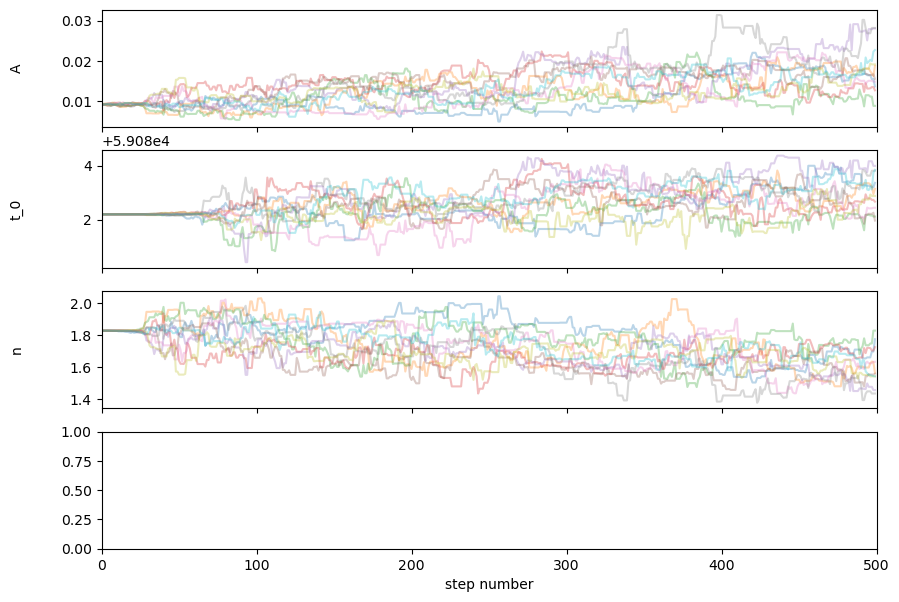

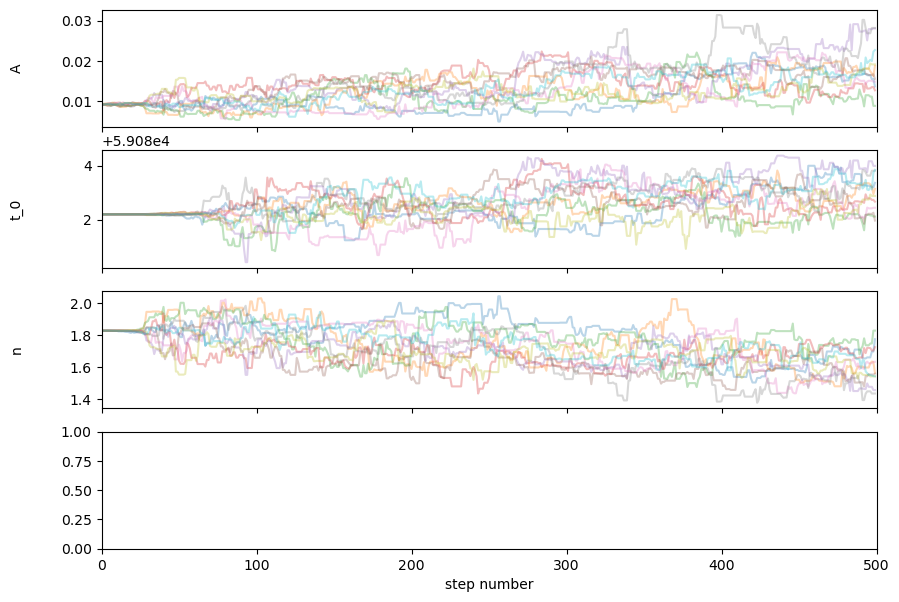

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

put_label_walk = ['A', 't_0', 'n']
new_max = run_walkers(sampler_early[0], put_label_walk, axes, 3)
print (new_max)
plt.show()

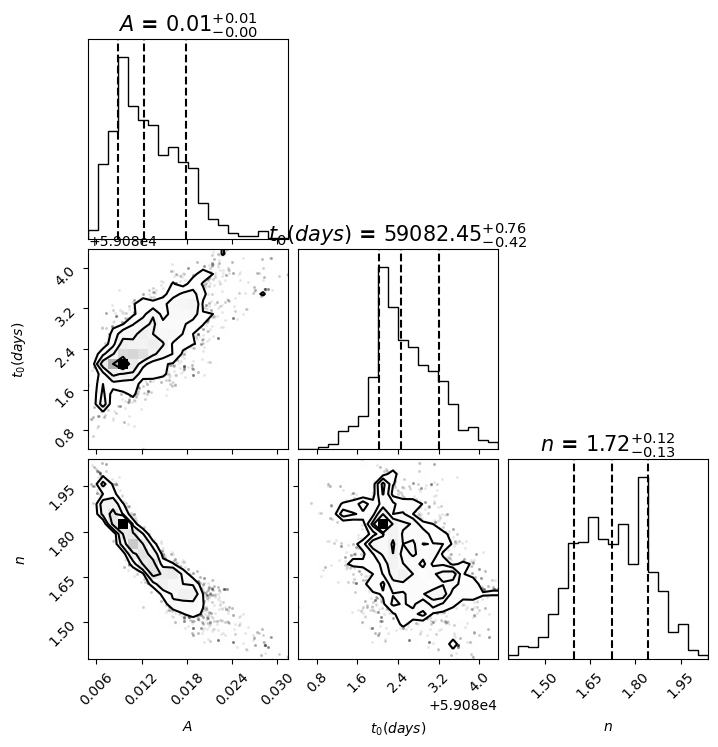

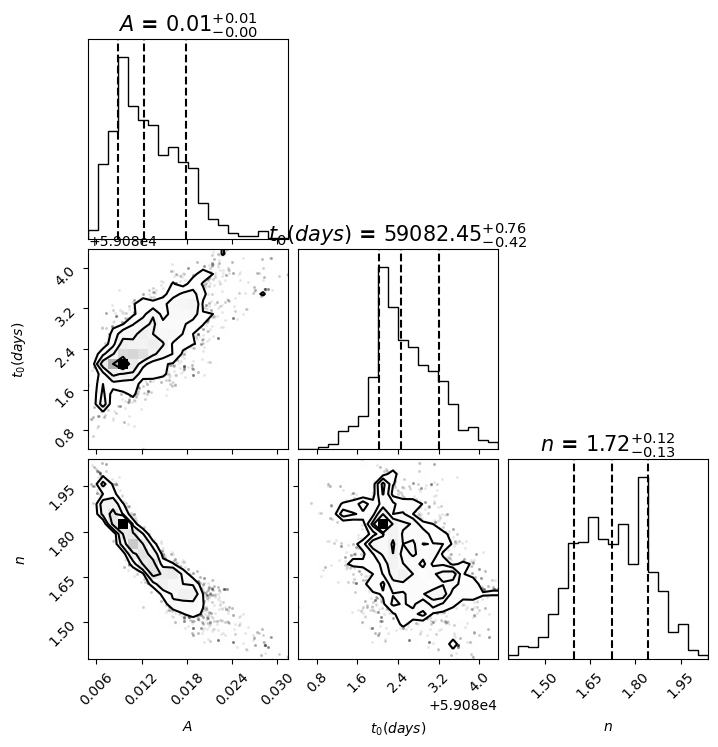

In [17]:
put_label_corn = [r'$A$', r'$t_{0}(days)$', r'$n$']

corner_plot(sampler_early, put_label_corn, soln_early, 3)
plt.show();

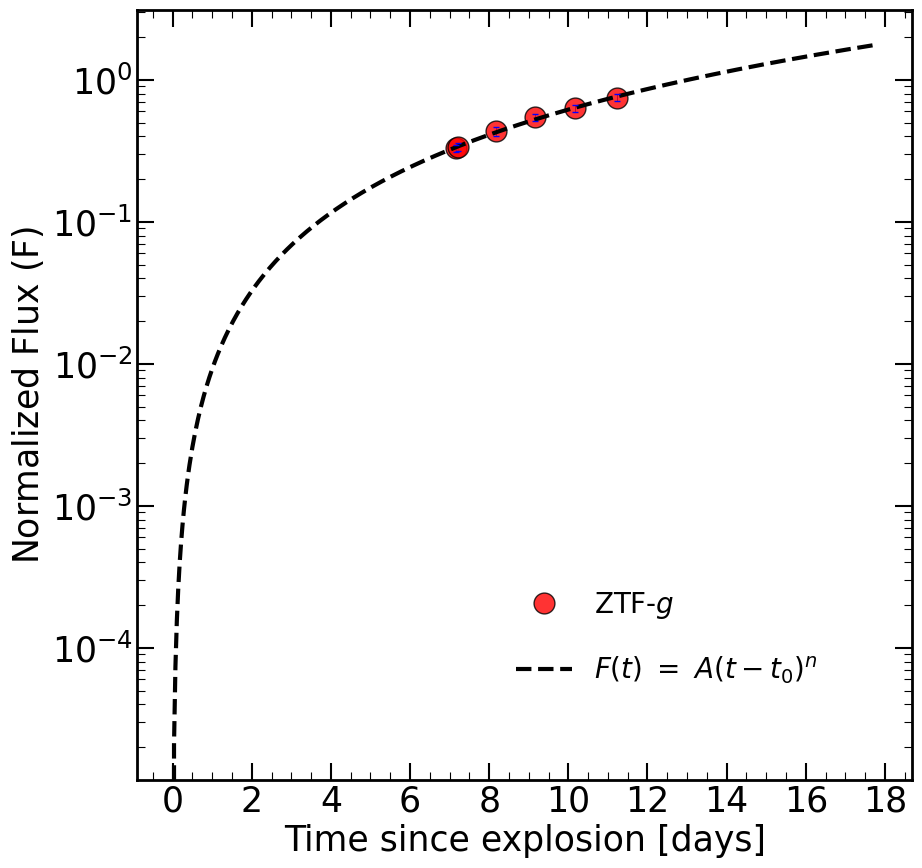

In [22]:
x_data = np.linspace(soln_early[1], 59100, 500)

fig_app = plt.figure(figsize = (10, 10))
plt.rcParams['axes.linewidth'] = 2
ax = fig_app.add_subplot(111)
plot_params('A', ax, ml_x = 2, mil_x = 0.5, ml_y = 0.5, mil_y=0.1, invert=False)
legend_properties = {'size':15, 'weight':'book'}

ax.plot(x-soln_early[1], y_norm, marker='o', ms=15, label=r'ZTF-$g$', alpha=0.8, mfc='red',  mec='black', ls= ' ')
#exp_date = popt[1] + epoch
ax.plot(x_data-soln_early[1], fit_fireball(soln_early, x_data), 'k--', lw=3, 
        label=r'$F(t)\ =\ A(t-t_{0})^{n}$')
ax.errorbar(x-soln_early[1], y_norm, yerr = y_norm_err, fmt = '',
                c = 'blue', ls = '', lw = 0.7, capsize=2, capthick=1)
            
ax.set_yscale("log")

ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 1.5, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 0.8, labelsize = 12)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 25)
    #tick.label1.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 25)
    
ax.set_xlabel('Time since explosion [days]', fontsize = 25)
ax.set_ylabel(r'$\rm Normalized\ Flux\ (F)$', fontsize = 25);    
    
ax.legend(fontsize=20, loc='lower right', borderaxespad=3, labelspacing=1.2, frameon=False, fancybox=False,
          shadow=False)

plt.savefig("/home/anirban/2020sck/Results/New_Results/Results/Plots/Fit_fireball.png",
           dpi=300, bbox_inches='tight', facecolor='white');

plt.show();

In [104]:
soln_early[1]

59082.3866254235

In [154]:
ztf_lc_df_g_fb

JD FILTER       FMAG      FERR     Phase     AbsMag    AbsErr  \
2  59089.366146      g  17.473309  0.044086 -8.824832 -16.861923  0.224327   
3  59089.416146      g  17.447147  0.052101 -8.775668 -16.888085  0.226039   
4  59090.367650      g  17.175106  0.054729 -7.840068 -17.160126  0.226659   
5  59091.363090      g  16.926779  0.040981 -6.861268 -17.408453  0.223737   
6  59092.363866      g  16.771160  0.038901 -5.877222 -17.564072  0.223366   
7  59093.435972      g  16.583841  0.047199 -4.823036 -17.751391  0.224959   

           Flux       FluxErr           Lum       Lum_Err  
2  6.176883e-16  2.956607e-17  3.670888e+38  7.439568e+37  
3  6.327525e-16  3.579376e-17  3.760413e+38  7.621004e+37  
4  8.129248e-16  4.830474e-17  4.831167e+38  9.791037e+37  
5  1.021836e-15  4.546640e-17  6.072716e+38  1.230721e+38  
6  1.179312e-15  4.980987e-17  7.008587e+38  1.420388e+38  
7  1.401381e-15  7.181502e-17  8.328331e+38  1.687853e+38

In [164]:
JD_max_g = 2459099.14
JD_exp = 2459082.39
JD_max_g_err = 0.34
JD_exp_err = 1.57


In [172]:
abs_max = cal_flux(16.34, 0.03, 'r', name='')[0]
abs_max_err = cal_flux(16.34, 0.03, 'r', name='')[1]

print (abs_max, abs_max_err)

-17.96272 0.22195398285093598


In [ ]:
16.41-(3.07*)